In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [2]:
voice_data = pd.read_csv('data/voice_gender.csv')
# label encoding
voice_data['label'] = voice_data['label'].apply(lambda x: 1 if x == 'male' else 0)
display(voice_data.head())
display(f"Null rows: {voice_data.isnull().sum().sum()}")

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402905,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,1
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,1
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,1
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,1
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,1


'Null rows: 0'

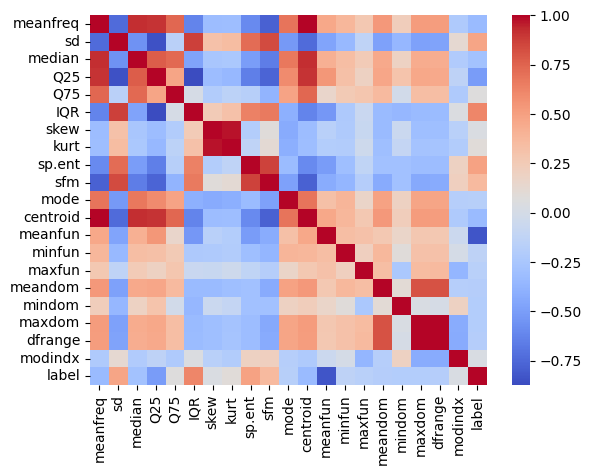

meanfun     0.833921
IQR         0.618916
Q25         0.511455
sp.ent      0.490552
sd          0.479539
sfm         0.357499
centroid    0.337415
meanfreq    0.337415
median      0.283919
Name: label, dtype: float64

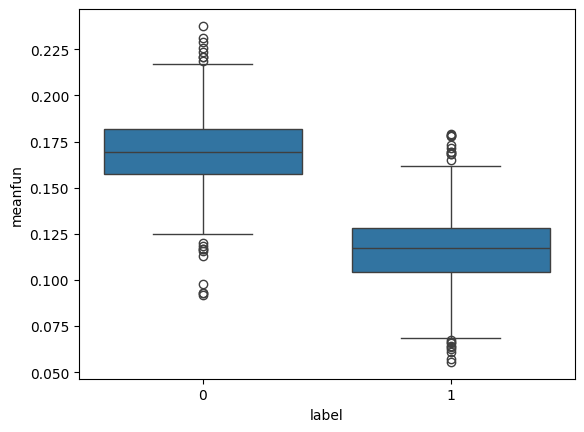

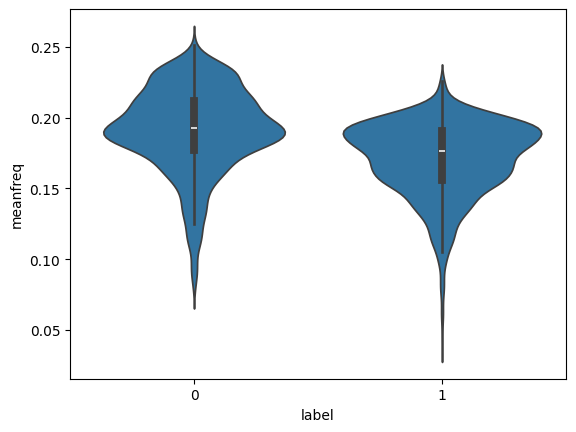

In [3]:
# Матрица корреляции параметров
corr_matrix = voice_data.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.show()
display(corr_matrix['label'].apply(abs).sort_values(ascending=False)[1:10])

# Усатый график
sns.boxplot(x='label', y='meanfun', data=voice_data)
plt.show()

# Виолончельный график
sns.violinplot(x='label', y='meanfreq', data=voice_data)
plt.show()


In [4]:
# Разделение данных на признаки и целевую переменную
voice_data['label'] = voice_data['label'].apply(lambda x: 'male' if x == 1 else 'female')
X = voice_data.drop('label', axis=1)
y = voice_data['label']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
display(f'Train shape: {X_train.shape}')
display(f'Test shape: {X_test.shape}')

'Train shape: (2534, 20)'

'Test shape: (634, 20)'

## Задание 1. Решающие пни.

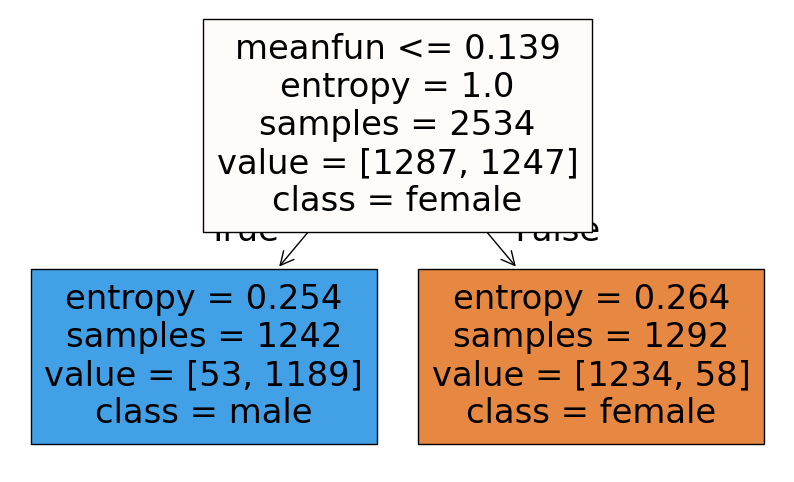

Признак в корневой вершине: meanfun
Пороговое значение: 0.139
Процент наблюдений, удовлетворяющих условию: 49.0%
Accuracy на тестовой выборке: 0.943


In [5]:
dt_stump = tree.DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=42)
dt_stump.fit(X_train, y_train)

# Визуализация дерева
plt.figure(figsize=(10, 6))
tree.plot_tree(dt_stump, feature_names=X.columns, filled=True, class_names=dt_stump.classes_)
plt.show()

# 1. Признак в корневой вершине
print(f"Признак в корневой вершине: {X.columns[dt_stump.tree_.feature[0]]}")

# 2. Пороговое значение
print(f"Пороговое значение: {dt_stump.tree_.threshold[0]:.3f}")

# 3. Процент наблюдений, удовлетворяющих условию в корневой вершине
mask = X_train.iloc[:, dt_stump.tree_.feature[0]] <= dt_stump.tree_.threshold[0]
print(f"Процент наблюдений, удовлетворяющих условию: {mask.mean()*100:.1f}%")

# 4. Accuracy на тестовой выборке
y_pred = dt_stump.predict(X_test)
print(f"Accuracy на тестовой выборке: {metrics.accuracy_score(y_test, y_pred):.3f}")


## Задание 2. Увеличим глубину дерева.

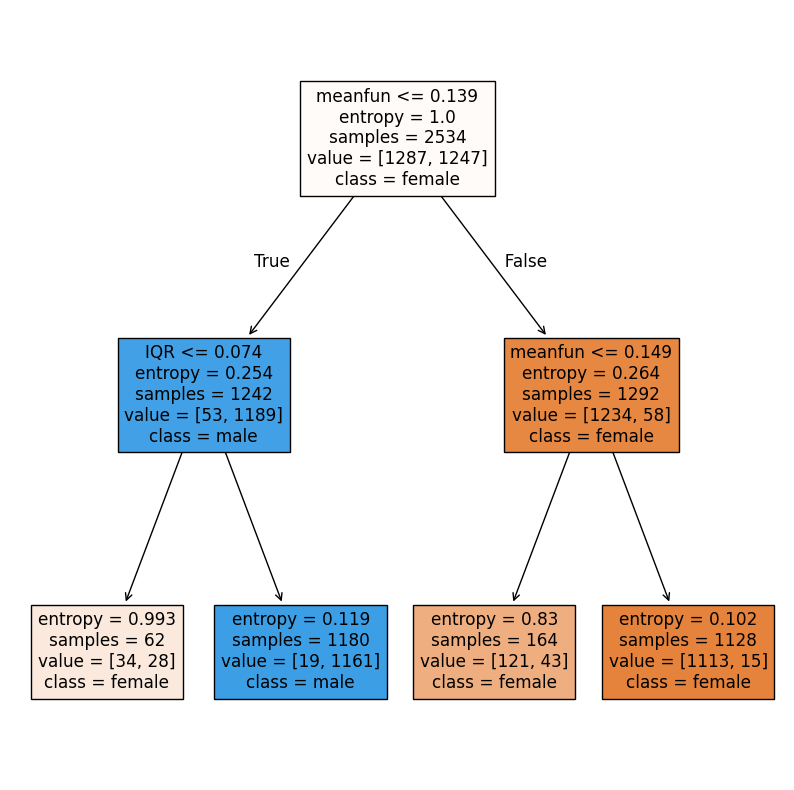

Используемые признаки: IQR, meanfun
Количество листьев female в модели: 3
Accuracy на тестовой выборке: 0.940


In [6]:

dt_depth2 = tree.DecisionTreeClassifier(max_depth=2, criterion='entropy', random_state=42)
dt_depth2.fit(X_train, y_train)

# Визуализация дерева
plt.figure(figsize=(10, 10))
tree.plot_tree(dt_depth2, feature_names=X.columns, filled=True, class_names=dt_depth2.classes_)
plt.show()

# 1. Используемые признаки
used_features = np.unique(dt_depth2.tree_.feature[dt_depth2.tree_.feature != -2])
print(f"Используемые признаки: {', '.join(X.columns[used_features].to_list())}")

# 2. Количество листьев в модели с class = female в обученной модели
n_leaves = 0
left_nodes = dt_depth2.tree_.children_left
for i, val in enumerate(dt_depth2.tree_.value[:, :, 0]):
    if left_nodes[i] == -1:
        n_leaves += 1 if val >= 0.5 else 0
print(f"Количество листьев female в модели: {n_leaves}")


# 3. Accuracy на тестовой выборке
y_pred = dt_depth2.predict(X_test)
print(f"Accuracy на тестовой выборке: {metrics.accuracy_score(y_test, y_pred):.3f}")


## Задание 3. Дадим дереву решений большую свободу.

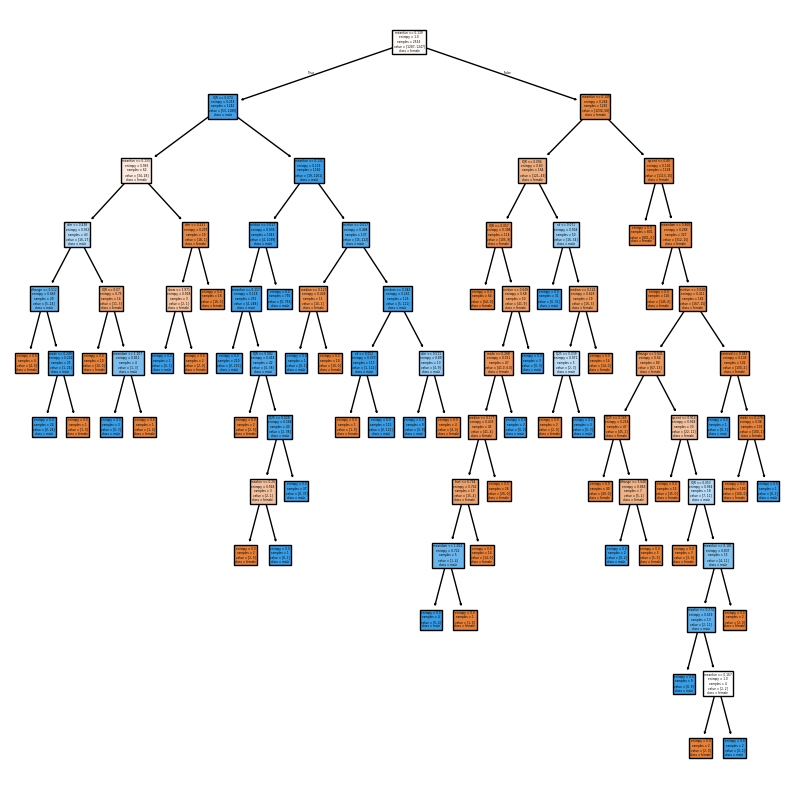

Глубина дерева: 11
Количество листьев: 46
Accuracy на обучающей выборке: 1.000
Accuracy на тестовой выборке: 0.962


In [7]:
dt_free = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
dt_free.fit(X_train, y_train)

# Визуализация дерева
plt.figure(figsize=(10, 10))
tree.plot_tree(dt_free, feature_names=X.columns, filled=True, class_names=dt_free.classes_)
plt.show()

# 1. Глубина дерева
print(f"Глубина дерева: {dt_free.get_depth()}")

# 2. Количество листьев
print(f"Количество листьев: {dt_free.get_n_leaves()}")

# 3. Accuracy на обучающей и тестовой выборках
y_train_pred = dt_free.predict(X_train)
y_test_pred = dt_free.predict(X_test)

print(f"Accuracy на обучающей выборке: {metrics.accuracy_score(y_train, y_train_pred):.3f}")
print(f"Accuracy на тестовой выборке: {metrics.accuracy_score(y_test, y_test_pred):.3f}")


## Задание 4. Подбор гиперпараметров с помощью GridSearchCV

Критерий информативности: entropy
Оптимальная максимальная глубина: 6
Оптимальное min_samples_split: 3
Accuracy на обучающей выборке: 0.992
Accuracy на тестовой выборке: 0.962


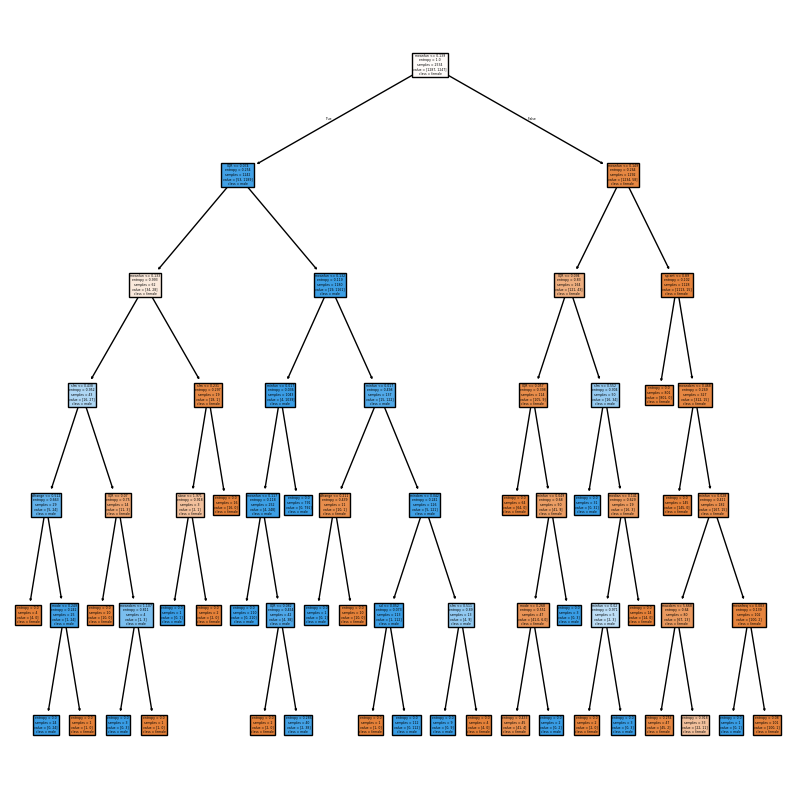

In [8]:
param_grid = {
   'criterion': ['gini', 'entropy'],
   'max_depth': [4, 5, 6, 7, 8, 9, 10],
   'min_samples_split': [3, 4, 5, 10]
}

cv = model_selection.StratifiedKFold(n_splits=5)

grid_search = model_selection.GridSearchCV(tree.DecisionTreeClassifier(random_state=0),
                                           param_grid=param_grid,
                                           cv=cv,
                                           scoring='accuracy')

grid_search.fit(X_train, y_train)

# 1. Критерий информативности наилучшей модели
print(f"Критерий информативности: {grid_search.best_params_['criterion']}")

# 2. Оптимальная максимальная глубина
print(f"Оптимальная максимальная глубина: {grid_search.best_params_['max_depth']}")

# 3. Оптимальное минимальное количество объектов для разбиения
print(f"Оптимальное min_samples_split: {grid_search.best_params_['min_samples_split']}")

# 4. Accuracy на обучающей и тестовой выборках для наилучшей модели
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print(f"Accuracy на обучающей выборке: {metrics.accuracy_score(y_train, y_train_pred):.3f}")
print(f"Accuracy на тестовой выборке: {metrics.accuracy_score(y_test, y_test_pred):.3f}")

# Визуализация дерева
plt.figure(figsize=(10, 10))
tree.plot_tree(best_model, feature_names=X.columns, filled=True, class_names=best_model.classes_)
plt.show()


## Задание 5. Важность признаков для оптимального дерева

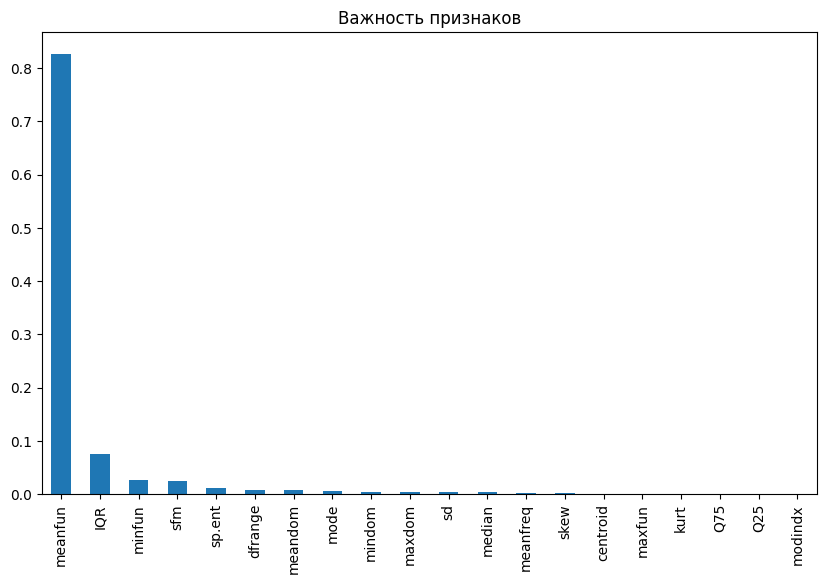

Топ-3 наиболее важных признаков: meanfun, IQR, minfun


In [9]:
feature_importances = pd.Series(best_model.feature_importances_, index=X.columns)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title('Важность признаков')
plt.show()

# Топ-3 наиболее важных признаков
top_3_features = feature_importances.sort_values(ascending=False).index[:3]
print(f"Топ-3 наиболее важных признаков: {', '.join(top_3_features)}")